In [149]:
# geral
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
from itertools import product

# modeling
# import sktime
# from sktime.utils.load_data import load_from_tsfile_to_dataframe
# from sktime.utils.load_data import load_from_ucr_tsv_to_dataframe
# from sktime.utils.load_data import load_from_arff_to_dataframe
# from sktime.transformers.series_as_features.shapelets import ContractedShapeletTransform
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh.feature_extraction import extract_features
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, classification_report

In [130]:
class BinaryClassifierContainer():

    def __init__(self, preprocessor=None, models=None):
        self.preprocessor = preprocessor
        self.models = models
        self.results_ = {}

    def calc_results(self, X_train, y_train, X_test, y_test, **kwargs):
        X_train_transf = self.preprocessor.transform(X_train)
        X_test_transf = self.preprocessor.transform(X_test)
        scoring = kwargs['scoring']

        for name, model in self.models.items():
            cv_results = cross_val_score(model, X_train_transf, y_train,
                                         **kwargs)

            # get test results
            model.fit(X_train_transf, y_train)
            y_pred = model.predict(X_test_transf)
            test_results = self._get_test_metrics(y_test, y_pred)

            # append results
            model_results = {
                'model': model,
                'cv_scoring': scoring,
                'cv_results': cv_results,
                'test_results': test_results
            }
            self._results[name] = model_results

    def _get_test_metrics(self, y_test, y_pred):
        return {
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }

    
def get_models(scale_pos_weight):
    return {
        'logreg': LogisticRegression(),
        'svc_lin': SVC(kernel='linear'),
        'svc_rbf': SVC(kernel='rbf'),
        'svc_sigm': SVC(kernel='sigmoid'),
        'rf': RandomForestClassifier(n_jobs=-1),
        'extra': ExtraTreesClassifier(n_jobs=-1),
        'gbtree': GradientBoostingClassifier(),
        'xgb': XGBClassifier(scale_pos_weight=scale_pos_weight),
        'lgbm': LGBMClassifier()
    }

def format_features(df):
    return (df
            .reset_index()
            .melt(id_vars='index', var_name='ts', value_name='value'))

def calc_results(estimator, cross_val_kws, train_X, train_y, test_X):
    scores = cross_val_score(estimator, train_X, train_y, **cross_val_kws)
    
    estimator.fit(train_X, train_y)
    predictions = estimator.predict(test_X)

    return estimator, scores, predictions

    
def print_results(scores, y_test, y_pred):
    print("CV Scores Mean: ", np.mean(scores))
    print(classification_report(y_test, y_pred))
    
    # plot confusion matrix
    
    f = plt.figure(figsize=(8,7))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, cmap='Blues', fmt='.0f',)
    plt.show()

In [3]:
warnings.simplefilter("ignore")

In [4]:
DATA_PATH = '../data/extracted'

In [5]:
np.random.seed(123)

___

# Get Data

In [17]:
data = pd.read_csv(os.path.join(DATA_PATH, "FordA_TRAIN.csv.gz"))
data = data.iloc[:, :-1]

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, class to 499
dtypes: float64(501)
memory usage: 13.8 MB


In [19]:
data_X = data.iloc[:, 1:]
data_y = data.iloc[:, 0]

In [38]:
assert sorted(data_X.index) == sorted(data_y.index)

## Split into training and testing

In [39]:
train_X, test_X, train_y, test_y = (
    train_test_split(data_X, data_y, stratify=data_y,
                     shuffle=True, random_state=123)
)

In [40]:
assert sorted(train_X.index) == sorted(train_y.index)

In [53]:
train_X_melt = (train_X
               .reset_index()
               .melt(id_vars='index', var_name='ts', value_name='value')
               .set_index(['index', 'ts']))
train_X_melt.head()

,,value
index,ts,
2752,0,1.790104
421,0,-0.197966
505,0,-0.769559
694,0,0.940676
1140,0,0.166898


In [141]:
assert set(idx_positive).intersection(idx_negative) == set()

In [54]:
idx_positive = train_y[train_y == 1].index.values
idx_negative = train_y[train_y == -1].index.values

In [55]:
n_samples = 6
random_positive_idx = np.random.choice(idx_positive, size=6, replace=False)
random_negative_idx = np.random.choice(idx_negative, size=6, replace=False)

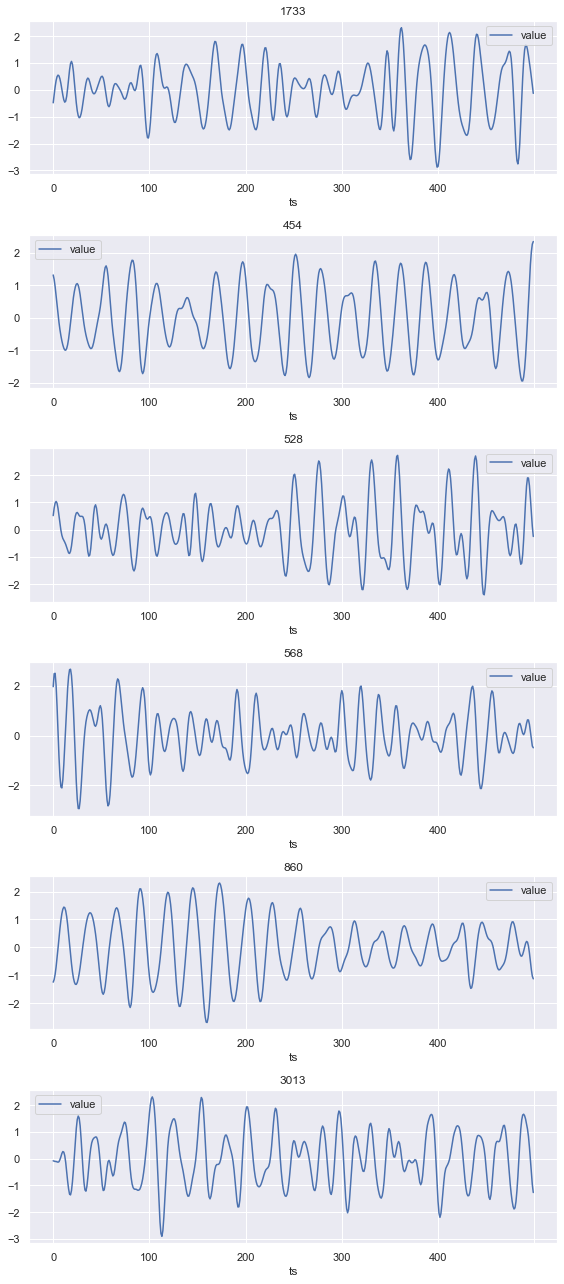

In [56]:
f, axs = plt.subplots(figsize=(8, 3*n_samples), nrows=n_samples)
for i, idx in enumerate(random_positive_idx):
    train_X_melt.loc[idx].plot(ax=axs[i])
    axs[i].set_title(idx)

plt.tight_layout()
plt.show()

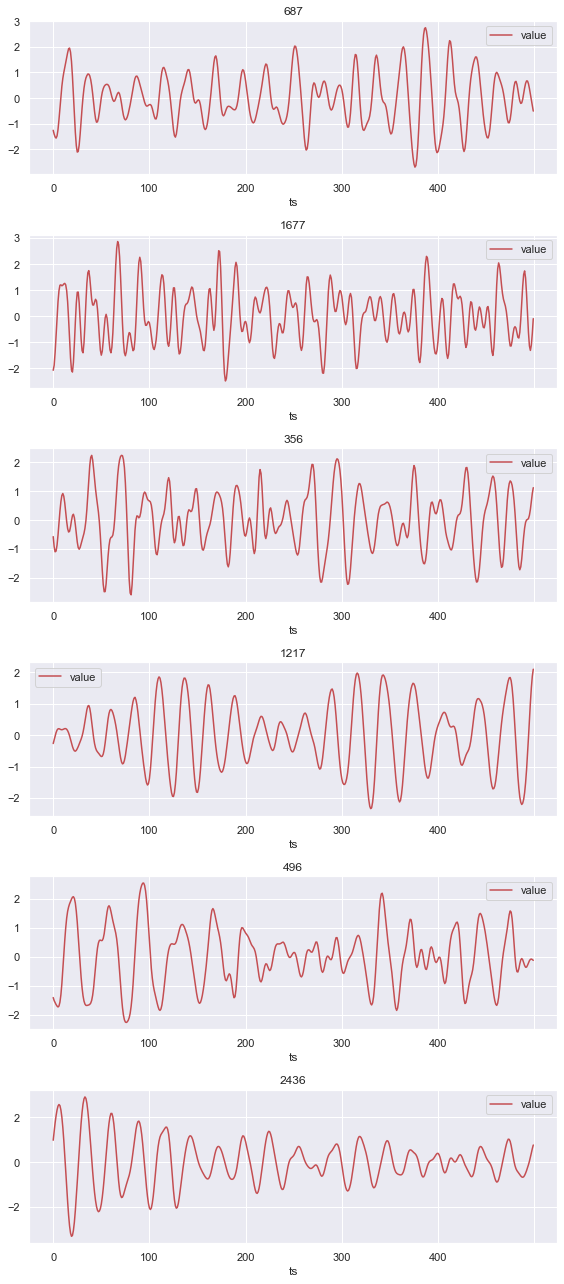

In [58]:
f, axs = plt.subplots(figsize=(8, 3*n_samples), nrows=n_samples)
for i, idx in enumerate(random_negative_idx):
    train_X_melt.loc[idx].plot(ax=axs[i], c='r')
    axs[i].set_title(idx)

plt.tight_layout()
plt.show()

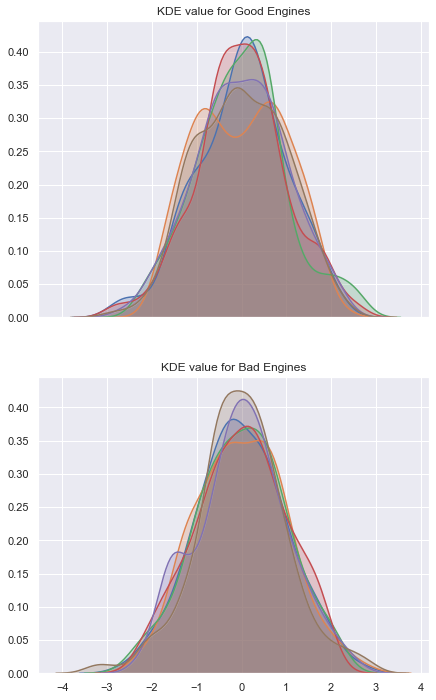

In [59]:
f, axs = plt.subplots(figsize=(7, 12), nrows=2,
                      sharex=True, sharey=True)
for idx in random_positive_idx:
    sns.distplot(train_X_melt.loc[idx], hist=False,
                 kde_kws={'shade': True}, ax=axs[0])
    axs[0].set_title('KDE value for Good Engines')

for idx in random_negative_idx:
    sns.distplot(train_X_melt.loc[idx], hist=False,
                 kde_kws={'shade': True}, ax=axs[1])
    axs[1].set_title('KDE value for Bad Engines')

plt.show()

**Obs**
- bad seems to be somewhat less normal => use normality test to separate?

# 1st approach: tsfresh

In [60]:
train_X_stacked = train_X_melt.reset_index()
train_X_stacked.head()

,index,ts,value
0,2752,0,1.790104
1,421,0,-0.197966
2,505,0,-0.769559
3,694,0,0.940676
4,1140,0,0.166898


**Note**:
no scaling is needed here **before** since all timeseries are on the same scale

In [61]:
train_X_extr = extract_features(train_X_stacked, column_id='index',
                                column_sort='ts',
                                default_fc_parameters=EfficientFCParameters(),
                                n_jobs=4)

Feature Extraction: 100%|██████████| 20/20 [07:10<00:00, 21.55s/it]


In [101]:
# extracting features from test
test_X_stacked = format_features(test_X)
test_X_extr = extract_features(test_X_stacked, column_id='index',
                                column_sort='ts',
                                default_fc_parameters=EfficientFCParameters(),
                                n_jobs=4)

Feature Extraction: 100%|██████████| 20/20 [02:25<00:00,  7.28s/it]


In [36]:
train_X_extracted.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","value__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""",...,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation,value__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
0,499.000001,201.612617,-0.005132,0.077591,0.123061,0.981790,-0.042278,-1.115422,0.506651,1.810807,...,1.0,-0.004518,-0.004283,-0.003233,0.0,0.0,0.0,0.998,0.0,-1.764393e+09
1,499.000000,173.350026,0.050234,0.117077,0.180290,1.307721,0.161383,-0.917663,0.647132,1.839293,...,1.0,0.006440,0.010403,-0.005324,0.0,0.0,0.0,0.998,0.0,-2.116525e+10
2,498.999998,188.742717,0.018044,0.056348,0.152620,1.213159,0.056659,-0.971904,0.459967,1.946056,...,1.0,-0.014969,-0.006315,-0.003683,0.0,0.0,0.0,0.998,0.0,-4.199983e+08
3,499.000001,187.211226,-0.001822,-0.024356,0.264462,1.020872,0.054905,-0.704142,0.380231,1.480024,...,1.0,0.011432,0.000562,0.001330,0.0,0.0,0.0,0.998,0.0,1.059632e+09
4,499.000001,246.460395,0.011495,0.033424,0.038234,1.169822,-0.101945,-1.839125,1.127160,2.166748,...,1.0,-0.033857,0.032445,0.123666,0.0,0.0,0.0,0.998,0.0,-2.385386e+09


In [64]:
train_X_extr.shape

(2700, 757)

## Manual Attempt \#1

In [96]:
preprocess_pipes[9]

Pipeline(steps=(('imputer_median', SimpleImputer(strategy='median')),
                ('power_transf_yj', PowerTransformer()),
                ('select_xtree',
                 SelectFromModel(estimator=ExtraTreesClassifier(n_jobs=-1),
                                 max_features=100))))

In [131]:
# sample model
preprocessing_pl = preprocess_pipes[9]
logreg = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1)

full_pl = Pipeline([
    ('preprocessing', preprocessing_pl),
    ('model', logreg)],
    verbose=True)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=  10.9s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
CV Scores Mean:  0.4575734581031237
              precision    recall  f1-score   support

        -1.0       0.51      0.55      0.53       462
         1.0       0.49      0.45      0.47       439

    accuracy                           0.50       901
   macro avg       0.50      0.50      0.50       901
weighted avg       0.50      0.50      0.50       901



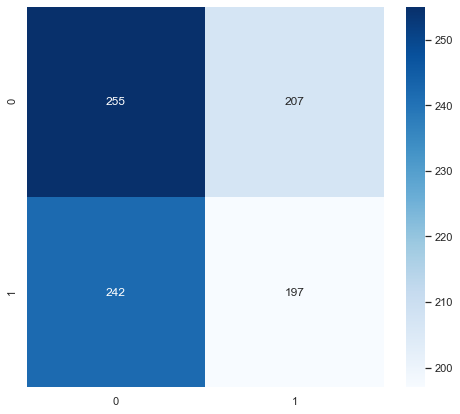

In [132]:
cross_val_kws = dict(cv=10, scoring='f1', n_jobs=-1)

model_fitted, model_scores, pred_y = \
    calc_results(full_pl, cross_val_kws, train_X_extr, train_y.values, test_X_extr)

print_results(model_scores, test_y, pred_y)

## Manual Attempt \#2

In [125]:
preprocessing_pl = Pipeline([
    ('imputer_median', SimpleImputer(strategy='median')),
    ('robust_scaler', StandardScaler())
])
logreg = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1)

full_pl = Pipeline([
    ('preprocessing', preprocessing_pl),
    ('model', logreg)],
    verbose=True)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.4s
[Pipeline] ............. (step 2 of 2) Processing model, total=   6.1s
CV Scores Mean:  0.4659899877113869
              precision    recall  f1-score   support

        -1.0       0.51      0.52      0.52       462
         1.0       0.49      0.48      0.48       439

    accuracy                           0.50       901
   macro avg       0.50      0.50      0.50       901
weighted avg       0.50      0.50      0.50       901



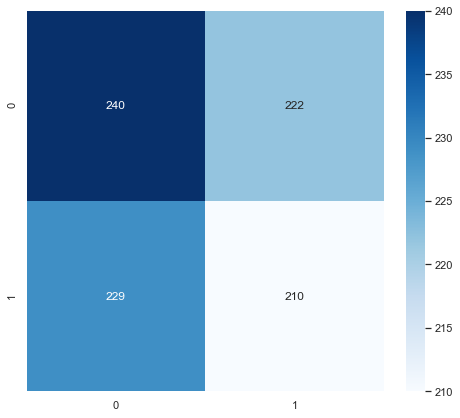

In [129]:
cross_val_kws = dict(cv=10, scoring='f1', n_jobs=-1)

model_fitted, model_scores, pred_y = \
    calc_results(full_pl, cross_val_kws, train_X_extr, train_y.values, test_X_extr)

print_results(model_scores, test_y, pred_y)

## Manual Attempt \#3

In [137]:
preprocessing_steps_03 = [
    ('imputer_median', SimpleImputer(strategy='median')),
    ('select_xtree', SelectFromModel(estimator=ExtraTreesClassifier(n_jobs=-1),
                                     max_features=100)),
    ('power_transf_yj', PowerTransformer())
]

preprocessing_pl_03 = Pipeline(
    steps=preprocessing_steps_03,
    verbose=True)

In [138]:
model_03 = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1)

estimator_03 = Pipeline([
    ('preprocessing', preprocessing_pl_03),
    ('model', model_03)],
    verbose=True)

[Pipeline] .... (step 1 of 3) Processing imputer_median, total=   0.3s
[Pipeline] ...... (step 2 of 3) Processing select_xtree, total=   1.3s
[Pipeline] ... (step 3 of 3) Processing power_transf_yj, total=   1.1s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   2.7s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.6s
CV Scores Mean:  0.4617952895452489
              precision    recall  f1-score   support

        -1.0       0.51      0.53      0.52       462
         1.0       0.48      0.45      0.47       439

    accuracy                           0.49       901
   macro avg       0.49      0.49      0.49       901
weighted avg       0.49      0.49      0.49       901



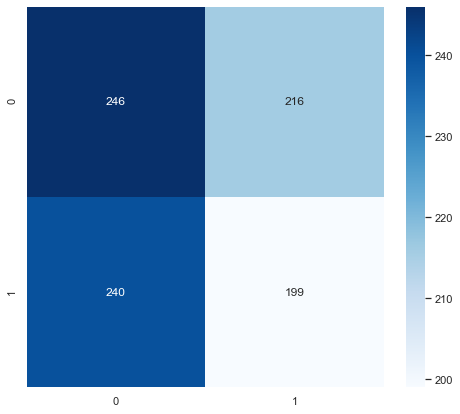

In [139]:
cross_val_kws = dict(cv=10, scoring='f1', n_jobs=-1)

model_fitted, model_scores, pred_y = \
    calc_results(estimator_03, cross_val_kws, train_X_extr, train_y.values, test_X_extr)

print_results(model_scores, test_y, pred_y)

## Manual Attempt \#4

[Pipeline] .... (step 1 of 3) Processing imputer_median, total=   0.3s
[Pipeline] ... (step 2 of 3) Processing power_transf_yj, total=   0.3s
[Pipeline] .... (step 3 of 3) Processing selection_chi2, total=  18.6s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=  19.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
CV Scores Mean:  0.43746212567551107
              precision    recall  f1-score   support

        -1.0       0.53      0.60      0.56       462
         1.0       0.51      0.44      0.47       439

    accuracy                           0.52       901
   macro avg       0.52      0.52      0.52       901
weighted avg       0.52      0.52      0.52       901



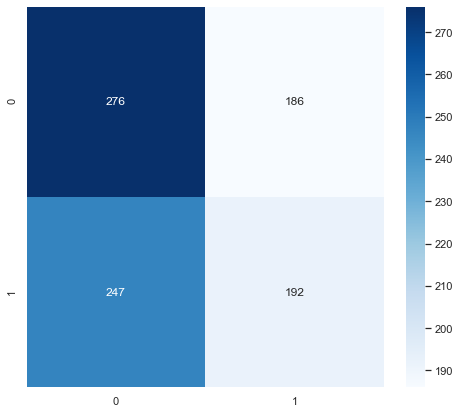

In [150]:
preprocessing_steps_04 = [
    ('imputer_median', SimpleImputer(strategy='median')),
    ('power_transf_yj', RobustScaler()),
    ('selection_chi2', SelectKBest(mutual_info_classif, k=50))
]

preprocessing_pl_04 = Pipeline(
    steps=preprocessing_steps_04,
    verbose=True)

model_04 = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1)

estimator_04 = Pipeline([
    ('preprocessing', preprocessing_pl_04),
    ('model', model_04)],
    verbose=True)

cross_val_kws = dict(cv=10, scoring='f1', n_jobs=-1)

model_fitted, model_scores, pred_y = \
    calc_results(estimator_04, cross_val_kws, train_X_extr, train_y.values, test_X_extr)

print_results(model_scores, test_y, pred_y)

## Try many preprocessing alternatives

In [92]:
random_state = 123

# hyper-parameter tuning
param_grid = {
    'imputer__strategy': ['median', 'most_frequent'],
    'one_class_svm__kernel': ['rbf', 'sigmoid', 'linear'],
    'one_class_svm__gamma': np.logspace(-5, 5, num=11),
    'local_outlier_factor__n_neighbors': [5, 10, 15, 20, 30],
    'quantile_transformer__output_distribution': ['uniform', 'normal']
}

# imputing
imputers = [
    ('imputer_median', SimpleImputer(strategy='median')),
    ('imputer_mode', SimpleImputer(strategy='most_frequent'))
]

# scalling
scalers = [
    ('std_scaler', StandardScaler()),
    ('robust_scaler', RobustScaler()),
    ('quantile_transf_uniform', QuantileTransformer(output_distribution='uniform')),
    ('quantile_transf_normal', QuantileTransformer(output_distribution='normal')),
    ('power_transf_yj', PowerTransformer(method='yeo-johnson'))
]

# feature selectors
k=100
feat_selectors = [
    ('select_linearsvc', SelectFromModel(LinearSVC(), max_features=k)),
    ('select_xtree', SelectFromModel(ExtraTreesClassifier(n_jobs=-1), max_features=k))
]

# create all preprocessor combinations
preprocess_steps = list(product(imputers, scalers, feat_selectors))

# turn them into a collection of pipelines
preprocess_pipes = list(map(Pipeline, preprocess_steps))

In [137]:
preprocessing_steps_04 = [
    ('imputer_median', SimpleImputer(strategy='median')),
    ('select_xtree', SelectFromModel(estimator=ExtraTreesClassifier(n_jobs=-1),
                                     max_features=100)),
    ('power_transf_yj', PowerTransformer())
]

preprocessing_pl_03 = Pipeline(
    steps=preprocessing_steps_03,
    verbose=True)

In [138]:
model_03 = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1)

estimator_03 = Pipeline([
    ('preprocessing', preprocessing_pl_03),
    ('model', model_03)],
    verbose=True)

[Pipeline] .... (step 1 of 3) Processing imputer_median, total=   0.3s
[Pipeline] ...... (step 2 of 3) Processing select_xtree, total=   1.3s
[Pipeline] ... (step 3 of 3) Processing power_transf_yj, total=   1.1s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   2.7s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.6s
CV Scores Mean:  0.4617952895452489
              precision    recall  f1-score   support

        -1.0       0.51      0.53      0.52       462
         1.0       0.48      0.45      0.47       439

    accuracy                           0.49       901
   macro avg       0.49      0.49      0.49       901
weighted avg       0.49      0.49      0.49       901



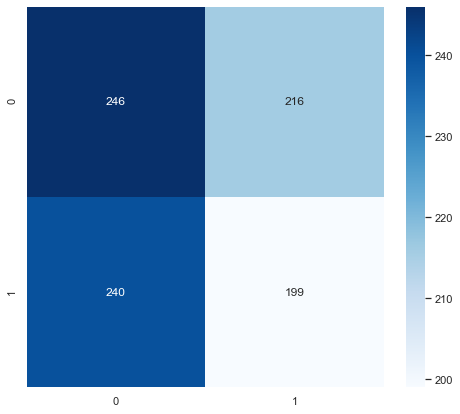

In [139]:
cross_val_kws = dict(cv=10, scoring='f1', n_jobs=-1)

model_fitted, model_scores, pred_y = \
    calc_results(estimator_03, cross_val_kws, train_X_extr, train_y.values, test_X_extr)

print_results(model_scores, test_y, pred_y)